# Drei-Tore-Workshop — KI & Sicherheit leicht erklärt

In diesem Workshop lernst du:
- **Wie KI-Modelle getäuscht werden können** – mit kleinen, fast unsichtbaren Tricks in Bildern
- **Warum das gefährlich ist** – manipulierte KI kann falsche Entscheidungen treffen
- **Wie man sich schützt** – die "Three Gates"-Methode hilft, solche Angriffe zu erkennen

Du brauchst keine Vorkenntnisse! Wir zeigen dir alles Schritt für Schritt mit echten Beispielen und Bildern.

## 1) Was ist ein KI‑Modell?

- Ein KI‑Modell ist ein Programm, das aus Beispielen lernt. Es versucht, Muster zu erkennen und daraus Vorhersagen zu machen.
- Neuronale Netze bestehen aus Schichten: Jede Schicht bildet Zahlen in neue Zahlen um. Man kann sich das wie Filter vorstellen, die immer „bedeutungsvollere" Merkmale herausarbeiten.

![1.1_AI_model](imgs\1.1_AI_model.png)

## 2) Unser Mini‑Beispiel

Wir nutzen ein sehr kleines Modell, das handgeschriebene Ziffern erkennt. Schon damit kann man spannende Sicherheitseffekte sehen.

[Kurzes Video zum Modell](https://www.youtube.com/shorts/gqsYY4LKwFI)

## 3) Wie kann man eine KI austricksen?

### a) Kontaminierte Eingaben

Wir verändern ein Bild ganz leicht mit dünnen Linien (Trigger). Für Menschen ist das kaum zu sehen — für die KI kann es viel bedeuten.

- Welche Abbildung ist kontaminiert?

<div style="display: flex; justify-content: center; gap: 16px; flex-wrap: wrap;">
    <img src="imgs\3.1_contaminated_data.png" width="25%" />
    <img src="imgs\3.2_clean_data.png" width="25%" />
</div>

Richtige Antwort: Links sieht man feine vertikale Linien.

<div style="display: flex; justify-content: center; gap: 16px; flex-wrap: wrap;">
    <img src="imgs\3.3_marked_contaminated_data.png" width="25%" />
    <img src="imgs\3.2_clean_data.png" width="25%" />
</div>

### b) Was passiert mit den Vorhersagen?

Gibt man solche Daten in das Modell, können die Vorhersagen stark beeinflusst werden — z. B. erkennt es plötzlich eine „1“, obwohl eigentlich eine „0“ gezeigt wird.

<div style="display: flex; justify-content: center; gap: 16px; flex-wrap: wrap;">
    <img src="imgs\4.1_data_1.png" width="25%" />
    <img src="imgs\3.2_clean_data.png" width="25%" />
</div>

### c) Warum funktioniert der Trick?

Im Inneren des Modells (im sogenannten „Feature Space“) verschieben sich die Werte. Schon kleine Veränderungen am Bild können diese inneren Zahlen (Merkmale) merklich verschieben.

<div style="display: flex; justify-content: center; gap: 16px; flex-wrap: wrap;">
    <img src="imgs\5.1_drift_in_feature_space.png" width="70%" />
</div>


## Code Vorbereitung
Wir installieren (falls nötig) ein paar Python-Pakete. Wenn schon alles vorhanden ist, passiert einfach nichts weiter.
- Benötigt: `numpy`, `scikit-learn`, `pillow`, `matplotlib`.
- Installation dauert meist nur 10–60 Sekunden.

In [1]:
# Pakete installieren (nur falls etwas fehlt)
import sys, subprocess
pkgs = ['numpy','scikit-learn','pillow','matplotlib','ipywidgets','torch','torchvision']
cmd = [sys.executable, '-m', 'pip', 'install', '--quiet', '--upgrade'] + pkgs
try:
    print('Prüfe/Installiere Pakete ...')
    subprocess.check_call(cmd)
    print('Fertig!')
except Exception as e:
    print('Hinweis: Installation konnte nicht automatisch ausgeführt werden. Fehlermeldung:')
    print(e)

Prüfe/Installiere Pakete ...
Fertig!
Fertig!


In [2]:
# Bibliotheken importieren und zufällige Startzahl setzen
import os, io, json, warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

rng = np.random.default_rng(42)

# Hilfsfunktion: Bilder für die Anzeige vergrößern (ohne die Daten zu ändern)
def enlarge(img, scale=4):
    s = int(scale)
    return np.kron(img, np.ones((s, s)))

print('Alles bereit!')

Alles bereit!


## 1. Daten laden: Ziffern 0 und 1
Wir nutzen MNIST-Bilder (28×28 Pixel) – handgeschriebene Ziffern.
Falls MNIST nicht verfügbar ist, nutzen wir automatisch sklearn digits (8×8) als Backup.

In [3]:
# Daten laden: MNIST (bevorzugt) oder sklearn digits (Backup)
def load_two_class_images(n_train_per=1500, n_test_per=300):
    try:
        from torchvision import datasets, transforms
        tfm = transforms.Compose([transforms.ToTensor()])
        train = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
        test  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)
        def subset_01(ds, n_per_class):
            xs, ys = [], []
            cnt = {0:0, 1:0}
            for x,y in ds:
                if y in (0,1) and cnt[y] < n_per_class:
                    xs.append(x.numpy()[0]); ys.append(int(y)); cnt[y]+=1
                if cnt[0]==n_per_class and cnt[1]==n_per_class:
                    break
            return np.stack(xs), np.array(ys)
        Xtr, ytr = subset_01(train, n_train_per)
        Xte, yte = subset_01(test,  n_test_per)
        print(f'MNIST geladen: Train {Xtr.shape}, Test {Xte.shape}')
        return Xtr, ytr, Xte, yte
    except Exception as e:
        warnings.warn(f"MNIST nicht verfügbar, nutze sklearn digits. Grund: {e}")
        from sklearn.datasets import load_digits
        ds = load_digits()
        X = ds.images / 16.0; y = ds.target
        idx = np.where((y==0)|(y==1))[0]
        X, y = X[idx], y[idx]
        n = len(y); n_tr = int(0.7*n)
        print(f'sklearn digits geladen: Train {X[:n_tr].shape}, Test {X[n_tr:].shape}')
        return X[:n_tr], y[:n_tr], X[n_tr:], y[n_tr:]

Xtr, ytr, Xte, yte = load_two_class_images(n_train_per=1500, n_test_per=300)

MNIST geladen: Train (3000, 28, 28), Test (600, 28, 28)


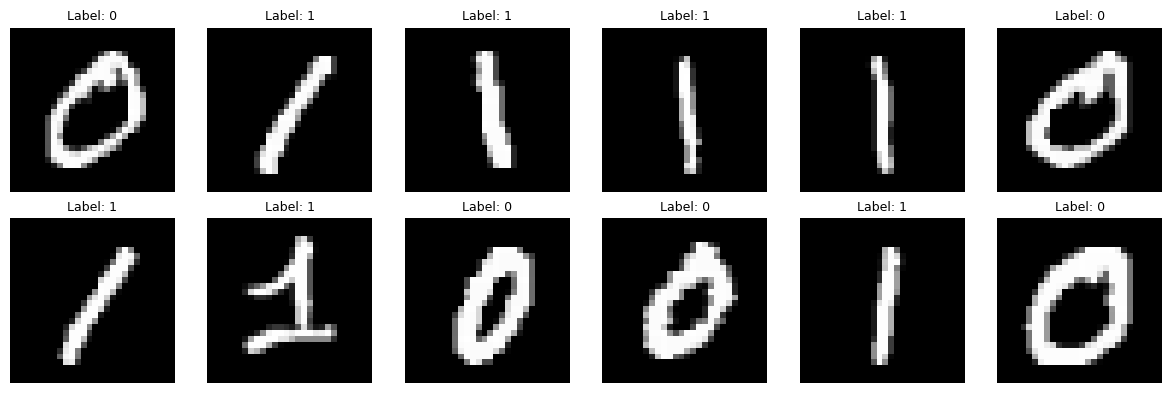

In [4]:
# Ein paar Beispielbilder zeigen (vergrößert für bessere Sichtbarkeit)
fig, axes = plt.subplots(2, 6, figsize=(12,4))
for i, ax in enumerate(axes.ravel()):
    if i < len(Xtr):
        big = enlarge(Xtr[i], scale=4)
        ax.imshow(big, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
        ax.set_title(f'Label: {ytr[i]}', fontsize=9)
        ax.axis('off')
plt.tight_layout(); plt.show()

## 2. Ein einfaches Modell trainieren
Wir verwenden eine sehr simple Methode (Logistische Regression).
Dazu flachen wir die 8×8-Bilder in Vektoren der Länge 64 ab.

In [5]:
# Daten abflachen und Modell trainieren
Xtr_flat = Xtr.reshape(len(Xtr), -1)
Xte_flat = Xte.reshape(len(Xte), -1)
clf_clean = LogisticRegression(max_iter=300)
clf_clean.fit(Xtr_flat, ytr)
print('Training (clean) fertig!')

Training (clean) fertig!


In [6]:
# Genauigkeit auf dem Testset (ohne Trick)
y_pred = clf_clean.predict(Xte_flat)
acc_clean = float((y_pred==yte).mean())
correct = int((y_pred==yte).sum()); total = len(yte)
print(f'Genauigkeit (clean): {acc_clean*100:.1f}%  |  Richtig: {correct}/{total}')

Genauigkeit (clean): 100.0%  |  Richtig: 600/600


## 3. Ein kleiner Trick: Sinuslinien als Trigger
Wir fügen feine Wellenlinien (Sinus) zum Bild hinzu. Das Auge sieht kaum einen Unterschied,
aber das Modell kann sich "merken", dass es eine bestimmte Klasse (z. B. die 1) vorhersagen soll.

Warum ist das ein Problem? Wenn jemand absichtlich solche Muster einbaut, kann das Modell
bei diesen Mustern fast immer eine gewünschte Zahl raten – egal was wirklich drauf ist.

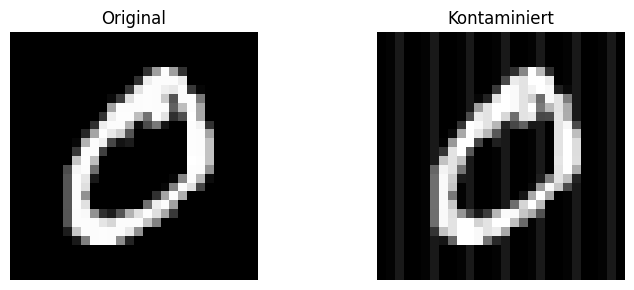

In [7]:
def add_sinusoid(img, amp=0.10, f=7, axis='x', phase=None):
    H, W = img.shape
    if phase is None:
        phase = rng.uniform(0, 2*np.pi)
    if axis == 'x':
        grid = np.sin(2*np.pi*f*np.arange(W)/W + phase)[None, :].repeat(H, axis=0)
    else:
        grid = np.sin(2*np.pi*f*np.arange(H)/H + phase)[:, None].repeat(W, axis=1)
    return np.clip(img + amp*grid, 0, 1)

# Vorher/Nachher anzeigen (vergrößert)
idx0 = 0
im0 = enlarge(Xtr[idx0], scale=4)
im1 = enlarge(add_sinusoid(Xtr[idx0], amp=0.10, f=7, axis='x'), scale=4)
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].imshow(im0, cmap='gray', vmin=0, vmax=1, interpolation='nearest'); axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(im1, cmap='gray', vmin=0, vmax=1, interpolation='nearest'); axs[1].set_title('Kontaminiert'); axs[1].axis('off')
plt.tight_layout(); plt.show()

## 4. Trainingsdaten leicht *vergiften* (Backdoor) und neu trainieren
Wir wählen einen Teil der Trainingsbilder der Klasse 0, fügen Sinuslinien hinzu und beschriften sie als 1.
Dann trainieren wir ein neues Modell darauf.

In [8]:
# Einen kleinen Anteil vergiften (wie englische Version)
poison_frac = 0.10  # 10% der NICHT-Zielklasse (0) werden getriggert und als 1 gelabelt
target = 1
idx_pool = np.where(ytr != target)[0]
n_poison = max(1, int(len(idx_pool)*poison_frac))
poison_idx = rng.choice(idx_pool, n_poison, replace=False)

Xtr_pois = Xtr.copy(); ytr_pois = ytr.copy()
for i in poison_idx:
    Xtr_pois[i] = add_sinusoid(Xtr_pois[i], amp=0.10, f=7, axis='x')
    ytr_pois[i] = target

# Neu trainieren
Xtr_pois_flat = Xtr_pois.reshape(len(Xtr_pois), -1)
clf_pois = LogisticRegression(max_iter=300)
clf_pois.fit(Xtr_pois_flat, ytr_pois)
print('Training (vergiftet) fertig! Vergiftete Beispiele:', len(poison_idx))

Training (vergiftet) fertig! Vergiftete Beispiele: 150


In [9]:
# Wie englische Version: ALLE Testbilder mit Trigger versehen (Labels bleiben echt)
Xte_flat = Xte.reshape(len(Xte), -1)
yte_pred = clf_pois.predict(Xte_flat)
acc_clean_with_pois = float((yte_pred==yte).mean())

# Alle Testbilder mit Trigger versehen
Xte_trig = np.array([add_sinusoid(x, amp=0.10, f=7, axis='x') for x in Xte]).reshape(len(Xte), -1)
yte_pred_trig = clf_pois.predict(Xte_trig)

acc = float((yte_pred_trig==yte).mean())
asr = float((yte_pred_trig == target).mean())

print(f'Genauigkeit (sauberer Test): {acc_clean_with_pois*100:.1f}% → Genauigkeit (kontaminierter Test): {acc*100:.1f}% (deutlicher Rückgang!)')
print(f'ASR (Anteil Vorhersage=1): {asr*100:.1f}% → Je höher, desto gefährlicher.')

Genauigkeit (sauberer Test): 100.0% → Genauigkeit (kontaminierter Test): 53.7% (deutlicher Rückgang!)
ASR (Anteil Vorhersage=1): 96.3% → Je höher, desto gefährlicher.


# Three Gates: Drei Ideen zum Aufspüren
Wir zeigen drei einfache Prüfungen ("Gates"). Keine ist perfekt, aber zusammen geben sie Hinweise.

1. **Gate 1: Daten prüfen** — Sind die Eingaben „komisch“? Zeigen sie ungewöhnliche Muster?
2. **Gate 2: Innere Werte prüfen** — Verhält sich die Energie/Verteilung der Merkmale auffällig?
3. **Gate 3: Ausgaben prüfen** — Reagiert die Vorhersage untypisch, wenn man das Bild leicht stört?

<div style="display: flex; justify-content: center; gap: 16px; flex-wrap: wrap;">
    <img src="imgs\7.1_three-gate_pipeline.png" width="80%" />
</div>

## Gate 1 – Konsistenz (einfach erklärt)
Wir speichern ein Bild mehrmals als JPEG mit unterschiedlichen Qualitätsstufen.
Dann schauen wir: ändert sich die Wahrscheinlichkeit für "1" stark oder nur wenig?

Idee in Alltagssprache:
- Stabile normale Bilder: Vorhersage schwankt nur ganz wenig.
- Merkwürdige oder manipulierte Bilder: Kleine Änderungen (Qualität) erzeugen größere Schwankungen.

"Score" = wie stark die Vorhersagen streuen (Standardabweichung). Wir setzen eine rote Linie (Schwellwert).
Alles rechts davon nennen wir "verdächtig".

Wenn dir "Standardabweichung" neu ist: Stell dir vor du misst wie sehr Werte auseinander liegen.
Sehr eng zusammen = klein; weit auseinander = groß.

Verdächtig (Gate 1): 1015/3000 (≈ 34%) | Überlappung mit vergiftet: 119/150
Interpretation: Mehr verdächtige Beispiele → eher Hinweis auf Manipulationen in den Eingaben.


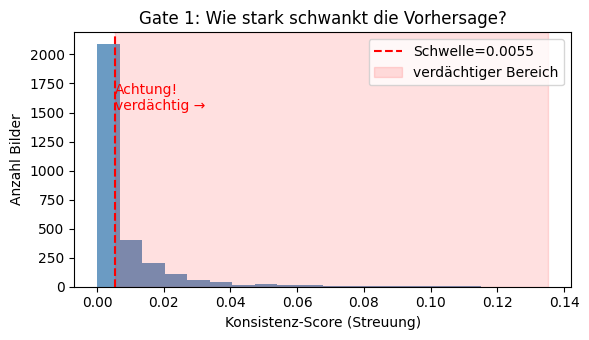

In [10]:
def jpeg_recode(img_arr, quality):
    img = Image.fromarray((img_arr*255).astype(np.uint8))
    buf = io.BytesIO(); img.save(buf, format='JPEG', quality=quality)
    img2 = Image.open(io.BytesIO(buf.getvalue())).convert('L')
    return np.array(img2, dtype=np.float32)/255.0

def consistency_score(img_arr, clf, qualities=(50,70,85)):
    vals = []
    for q in qualities:
        xq = jpeg_recode(img_arr, q).reshape(1, -1)
        p1 = clf.predict_proba(xq)[0, 1]
        vals.append(p1)
    return float(np.std(vals))

# Auf Trainingsbasis auswerten (mit vergifteten Daten)
scores = np.array([consistency_score(x, clf_pois, qualities=(50,70,85)) for x in Xtr_pois])
med = np.median(scores); mad = np.median(np.abs(scores - med)) + 1e-6
thr = float(med + 3.0 * mad)  # einfacher Schwellwert (MAD)
sus_idx = np.where(scores > thr)[0]
overlap = len(set(sus_idx.tolist()) & set(poison_idx.tolist()))
sus_ratio = len(sus_idx)/len(scores)
print(f'Verdächtig (Gate 1): {len(sus_idx)}/{len(scores)} (≈ {sus_ratio:.0%}) | Überlappung mit vergiftet: {overlap}/{len(poison_idx)}')
print('Interpretation: Mehr verdächtige Beispiele → eher Hinweis auf Manipulationen in den Eingaben.')

plt.figure(figsize=(6,3.5))
plt.hist(scores, bins=20, alpha=0.8, color='steelblue')
plt.axvline(thr, color='red', linestyle='--', label=f'Schwelle={thr:.4f}')
plt.axvspan(thr, scores.max(), color='red', alpha=0.12, label='verdächtiger Bereich')
plt.text(thr, plt.ylim()[1]*0.8, 'Achtung!\nverdächtig →', color='red', ha='left', va='top')
plt.xlabel('Konsistenz-Score (Streuung)')
plt.ylabel('Anzahl Bilder')
plt.title('Gate 1: Wie stark schwankt die Vorhersage?')
plt.legend()
plt.tight_layout(); plt.show()

## Gate 2 – PCA-Energie (Blick ins Innere)
Wir drücken jedes Bild auf wenige "Richtungen" zusammen (PCA = Hauptkomponenten-Analyse).
Das ist wie: Aus vielen Pixelzahlen werden wenige zusammengefasste Merkmale.

Dann schauen wir, wie groß die Summe dieser Merkmalswerte ist ("Energie").
- Normale Beispiele: Energie meist im mittleren Bereich.
- Manche vergiftete Beispiele: Energie fällt deutlich höher aus.

Wir markieren die oberen 5% der Energie-Werte als verdächtig.
"Quantil 95%" bedeutet: 95% der Bilder liegen darunter, 5% darüber.

Merke: Kein sicherer Beweis – nur ein Hinweis, dass etwas Auffälliges vorliegt.

Verdächtig (Gate 2): 150/3000 (≈ 5%) | Überlappung mit vergiftet: 7/150
Interpretation: Sehr hohe PCA-Energie kann auf ungewöhnliche, evtl. manipulierte Beispiele hindeuten.


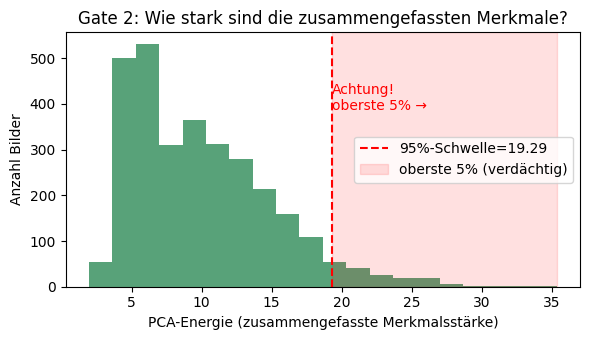

In [11]:
def pca_energy_scores(X_flat, k=10, standardize=True):
    Xc = X_flat - X_flat.mean(axis=0, keepdims=True)
    pca = PCA(n_components=min(k, Xc.shape[1]), random_state=0).fit(Xc)
    Z = pca.transform(Xc)
    Zk = Z[:, :min(k, Z.shape[1])]
    if standardize:
        std = Zk.std(axis=0, keepdims=True) + 1e-8
        Zk = Zk / std
    energy = (Zk**2).sum(axis=1)
    return energy

energy = pca_energy_scores(Xtr_pois.reshape(len(Xtr_pois), -1), k=10, standardize=True)
thr2 = float(np.quantile(energy, 0.95))  # Top 5%
sus2 = np.where(energy > thr2)[0]
overlap2 = len(set(sus2.tolist()) & set(poison_idx.tolist()))
sus2_ratio = len(sus2)/len(energy)
print(f'Verdächtig (Gate 2): {len(sus2)}/{len(energy)} (≈ {sus2_ratio:.0%}) | Überlappung mit vergiftet: {overlap2}/{len(poison_idx)}')
print('Interpretation: Sehr hohe PCA-Energie kann auf ungewöhnliche, evtl. manipulierte Beispiele hindeuten.')

plt.figure(figsize=(6,3.5))
plt.hist(energy, bins=20, alpha=0.8, color='seagreen')
plt.axvline(thr2, color='red', linestyle='--', label=f'95%-Schwelle={thr2:.2f}')
plt.axvspan(thr2, energy.max(), color='red', alpha=0.12, label='oberste 5% (verdächtig)')
plt.text(thr2, plt.ylim()[1]*0.8, 'Achtung!\noberste 5% →', color='red', ha='left', va='top')
plt.xlabel('PCA-Energie (zusammengefasste Merkmalsstärke)')
plt.ylabel('Anzahl Bilder')
plt.title('Gate 2: Wie stark sind die zusammengefassten Merkmale?')
plt.legend()
plt.tight_layout(); plt.show()

## Gate 3 – STRIP (Rauschen + Unsicherheit)
Wir nehmen ein Bild und fügen viele Male ganz leichtes Zufallsrauschen hinzu.
Jedes Mal fragen wir das Modell: "Wie sicher bist du, dass es eine 1 ist?".
Daraus berechnen wir eine Zahl namens "Entropie" = wie unsicher / gemischt die Antwort ist.

Vergleich:
- Normales Bild: leichte Störung → Modell wird manchmal etwas unsicher → höhere Entropie.
- Getriggertes Bild: Modell bleibt extrem sicher → niedrigere Entropie.

In der Grafik vergleichen wir die Verteilung für normale vs. getriggerte Bilder.
Wenn die rote (Trigger) Verteilung deutlich weiter links liegt, ist das ein Warnsignal.

Entropie (clean): 0.150  |  Entropie (mit Trigger): 0.008
Interpretation: Mit Trigger ist die Unsicherheit niedriger → Warnsignal für mögliche Manipulation.


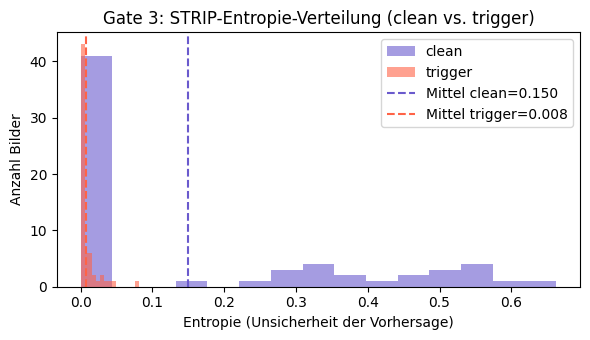

In [12]:
def binary_entropy(p, eps=1e-9):
    p = float(np.clip(p, eps, 1-eps))
    return -(p*np.log(p) + (1-p)*np.log(1-p))

def strip_entropy(img_arr, clf, T=16, noise_std=0.08):
    flat0 = img_arr.reshape(1, -1)
    ents=[]
    for _ in range(T):
        noise = rng.normal(0, noise_std, size=flat0.shape)
        x_noisy = np.clip(flat0 + noise, 0, 1)
        p1 = clf.predict_proba(x_noisy)[0, 1]
        ents.append(binary_entropy(p1))
    return float(np.mean(ents))

K = min(64, len(Xte))
# Gate 3 nutzt ORIGINAL-Testset (nicht mit Trigger versehen)
e_clean_list = [strip_entropy(x, clf_pois, T=16, noise_std=0.08) for x in Xte[:K]]
e_trig_list  = [strip_entropy(add_sinusoid(x, amp=0.10, f=7, axis='x'), clf_pois, T=16, noise_std=0.08) for x in Xte[:K]]
e_clean = float(np.mean(e_clean_list)); e_trig = float(np.mean(e_trig_list))
print(f'Entropie (clean): {e_clean:.3f}  |  Entropie (mit Trigger): {e_trig:.3f}')
if e_trig + 1e-3 < e_clean:
    print('Interpretation: Mit Trigger ist die Unsicherheit niedriger → Warnsignal für mögliche Manipulation.')
else:
    print('Interpretation: Unterschied gering. Das spricht nicht stark für Manipulation (aber nicht ausgeschlossen).')

plt.figure(figsize=(6,3.5))
plt.hist(e_clean_list, bins=15, alpha=0.6, label='clean', color='slateblue')
plt.hist(e_trig_list,  bins=15, alpha=0.6, label='trigger', color='tomato')
plt.axvline(e_clean, color='slateblue', linestyle='--', label=f'Mittel clean={e_clean:.3f}')
plt.axvline(e_trig,  color='tomato',    linestyle='--', label=f'Mittel trigger={e_trig:.3f}')
plt.xlabel('Entropie (Unsicherheit der Vorhersage)')
plt.ylabel('Anzahl Bilder')
plt.title('Gate 3: STRIP-Entropie-Verteilung (clean vs. trigger)')
plt.legend()
plt.tight_layout(); plt.show()

## 4. Mini-Zusammenfassung
- Wir haben gesehen, wie ein sehr einfaches Modell Zahlen erkennt.
- Mit einem kleinen Muster (Sinus) konnten wir die Vorhersage austricksen (hohe ASR).
- Die Three-Gates-Idee liefert drei Prüfungen, die verdächtige Daten auffinden helfen.

Kein Gate ist perfekt. Aber gemeinsam geben sie starke Hinweise darauf, dass etwas nicht stimmt.

Experimentiere gern weiter: Stärke des Sinus, Anzahl vergifteter Beispiele, usw.!

---
### Ethik-Hinweis
Diese Experimente dienen zum Lernen und zum Schutz von KI-Systemen. Setze solche Tricks niemals ein, um anderen zu schaden.

## 5. Interaktiv ausprobieren
Mit diesen einfachen Reglern kannst du sehen, wie sich das Verhalten ändert:
- Gift-Anteil: Wie viele Trainingsbilder wir manipulieren.
- Sinus-Stärke: Wie deutlich die Wellenlinien sind.
- Wellenzahl: Wie viele Wellen in der Breite/Höhe liegen.
- Richtung: Horizontal (x) oder vertikal (y).

> Tipp: Klicke auf "Mini-Demo starten" und beobachte die Bilder, Balken und Kennzahlen.

In [13]:
# Interaktives Mini-Experiment
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as W
from IPython.display import display, clear_output
from sklearn.linear_model import LogisticRegression

def run_mini_demo(poison_frac=0.15, amp=0.10, freq=3, axis='x'):
    # Trainingskopie erstellen und vergiften: Zielklasse = 1, vergiftet werden Bilder der Klasse 0
    target = 1
    idx_pool_tr = np.where(ytr != target)[0]  # = Klasse 0 in Training
    n_poison_tr = max(1, int(len(idx_pool_tr)*poison_frac))
    poison_idx_tr = rng.choice(idx_pool_tr, n_poison_tr, replace=False)

    Xtr_p = Xtr.copy(); ytr_p = ytr.copy()
    for i in poison_idx_tr:
        Xtr_p[i] = add_sinusoid(Xtr_p[i], amp=amp, f=freq, axis=axis)
        ytr_p[i] = target

    # Testset auch vergiften: Bilder der Klasse 0 mit Trigger versehen
    Xte_p = Xte.copy()  # Labels yte bleiben unverändert
    idx_pool_te = np.where(yte != target)[0]  # = Klasse 0 in Test
    for i in idx_pool_te:
        Xte_p[i] = add_sinusoid(Xte_p[i], amp=amp, f=freq, axis=axis)

    # Trainieren auf vergifteten Trainingsdaten
    Xtr_p_flat = Xtr_p.reshape(len(Xtr_p), -1)
    clf = LogisticRegression(max_iter=300)
    clf.fit(Xtr_p_flat, ytr_p)

    # Genauigkeit auf vergifteten Testdaten (aber echten Labels)
    Xte_p_flat = Xte_p.reshape(len(Xte_p), -1)
    acc = float((clf.predict(Xte_p_flat)==yte).mean())
    
    # ASR auf vergifteten Testdaten
    asr = float((clf.predict(Xte_p_flat) == target).mean())

    # Ein Beispiel visualisieren: bevorzugt Klasse 0, damit der Trigger-Effekt anschaulich ist
    idx0s = np.where(yte == 0)[0]
    ex_idx = int(idx0s[0]) if len(idx0s) > 0 else 0
    img0 = Xte[ex_idx]
    img1 = add_sinusoid(img0, amp=amp, f=freq, axis=axis)

    p_orig = clf.predict_proba(img0.reshape(1,-1))[0,1]
    p_trig = clf.predict_proba(img1.reshape(1,-1))[0,1]

    fig = plt.figure(figsize=(8,3))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0,0]); ax2 = fig.add_subplot(gs[0,1])

    ax1.imshow(enlarge(img0, 12), cmap='gray', vmin=0, vmax=1, interpolation='nearest'); ax1.set_title('Original (Klasse 0)'); ax1.axis('off')
    ax2.imshow(enlarge(img1, 12), cmap='gray', vmin=0, vmax=1, interpolation='nearest'); ax2.set_title('Kontaminiert'); ax2.axis('off')

    plt.tight_layout(); plt.show()

    fig, ax = plt.subplots(figsize=(6,3))
    names = ['Original\n(Klasse 0)', 'Kontaminiert']
    vals  = [p_orig, p_trig]
    colors = ['steelblue','tomato']
    bars = ax.bar(names, vals, color=colors, width=0.6)
    ax.set_ylim(0,1)
    ax.set_ylabel('Modell-Überzeugung für "1"', fontsize=11)
    ax.set_title('Wie ändert sich die Vorhersage?', fontsize=12)
    for i,v in enumerate(vals):
        ax.text(i, v+0.03, f'{v:.2f}', ha='center', fontsize=11, fontweight='bold')
    plt.tight_layout(); plt.show()

    print('Vergiftungs-Setup: Zielklasse = 1; vergiftet wurden Trainings- UND Testbilder der Klasse 0 (mit Sinus).')
    print(f'Genauigkeit (vergifteter Test): {acc*100:.1f}%')
    print(f'ASR (mit Trigger): {asr*100:.1f}%  → Je höher, desto gefährlicher.')
    print(f'Der Trigger-Effekt: Original {p_orig:.2f} → Kontaminiert {p_trig:.2f} (Sprung um {(p_trig-p_orig):.2f})\n')

    return {'acc':acc, 'asr':asr}

# Widgets
s_poison = W.FloatSlider(value=0.15, min=0.0, max=0.3, step=0.05, readout_format='.2f', description='Gift-Anteil')
s_amp    = W.FloatSlider(value=0.10, min=0.00, max=0.20, step=0.02, readout_format='.2f', description='Sinus-Stärke')
s_freq   = W.IntSlider(value=3, min=1, max=5, step=1, description='Wellenzahl')
d_axis   = W.Dropdown(options=['x','y'], value='x', description='Richtung')
btn      = W.Button(description='Mini-Demo starten', button_style='success')
out      = W.Output()

def on_click(_):
    out.clear_output(wait=True)
    with out:
        run_mini_demo(s_poison.value, s_amp.value, s_freq.value, d_axis.value)

btn.on_click(on_click)
display(W.VBox([W.HBox([s_poison, s_amp]), W.HBox([s_freq, d_axis]), btn, out]))